In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
def Backus(V,lamda, G ):
    """Computes stiffnesses of a layered medium using backus average model. Written by Jiaxin Yu (July 2021)

    Args:
        V (num or array-like, frac): volumetric fractions of N isotropic layering materials
        lamda (num or array-like): Lamé coefficients of N isotropic layering materials
        G (num or array-like, GPa): shear moduli of N isotropic layering materials
    Returns:
        C11,C33,C13,C44,C66 (num or array-like, GPa): Elastic moduli of the anisotropic layered media
    """    
    if isinstance(V, ( np.ndarray)) is False:
        V=np.array(V)
    V=V/np.sum(V)
    if isinstance(lamda, ( np.ndarray)) is False:
        lamda=np.array(lamda)
    if isinstance(G, ( np.ndarray)) is False:
        G=np.array(G)
    
    C33=np.dot(V, 1/(lamda+2*G)) **-1
    C44=np.dot(V, 1/G)**-1
    C66=np.dot(V, G)
    C13=np.dot(V, 1/(lamda+2*G)) **-1 * np.dot(V, lamda/(lamda+2*G))
    C11=np.dot(V, 4*G*(lamda+G)/(lamda+2*G))+np.dot(V, 1/(lamda+2*G))**-1 * np.dot(V, lamda/(lamda+2*G))**2
    
    return C11,C33,C13,C44,C66

def Backus_log(Vp,Vs,Den,Depth):
    """ Computes Backus Average from log data, notice that the Depth is 1d Vector including each top depth of layer and also the bottom of last layer. 

    Args:
        Vp (array): P wave velocities of layers [Vp1,Vp2...Vpn], size N
        Vs (array): S wave velocities of layers [Vs1,Vs2...Vsn], size N
        Den (array): Densities of layers, size N
        Depth (array): 1d depth, ATTENTION: each depth point
        corresponds to the top of thin isotropic layer, the bottom of the sedimentary package is the last depth point. [dep1,dep2,,,,,,depn, depn+1], size N+1

    Returns:
        _type_: _description_
    """    

    # compute lame constants from log data 
    G = Den*Vs**2
    lamda = Den*Vp**2 - 2*G
    # compute thickness of each layer given depth  
    thickness = np.diff(Depth)
    # Volume fraction
    V= thickness/thickness.sum()
    
    C11,C33,C13,C44,C66 = Backus(V,lamda, G )

    # Mass balance for density 
    den = np.dot(V, Den)

    return C11,C33,C13,C44,C66, den


In [7]:
from utils import*
from Fluid import *

In [10]:
DSdry= write_VTI_matrix(11,22,33,44,55)
DSdry

array([[ 11, -99,  33,   0,   0,   0],
       [-99,  11,  33,   0,   0,   0],
       [ 33,  33,  22,   0,   0,   0],
       [  0,   0,   0,  44,   0,   0],
       [  0,   0,   0,   0,  44,   0],
       [  0,   0,   0,   0,   0,  55]])

In [39]:
Kdry= 30                    
Gdry=36
K0=37                                       
phi=0.2
rho0=2.3
rhofl1=1.05
rhofl2=1.2
Kfl1= 2.3
Kfl2=2.4
eta1= 0.001
eta2= 0.002
kapa= 0.01
a= 0.0001
sg= 0.5
freq=1000 

In [1]:
72*2.5

180.0

In [9]:
114*3.34

380.76

In [12]:
36/1.852

19.438444924406046

In [ ]:
def Wyllie_Gregory(phi, d):
    """Compute permeability using Wyllie and Gregory model

    Args:
        phi (frac): porosity
        d (micro m):  mean particles size

    Returns:
        _type_: _description_
    """   

    k= 1.853*d**2*phi**3/(1-phi)**2
    return k

In [13]:
12*2.5

30.0

In [37]:
def White_Dutta_Ode(Kdry, Gdry, K0, phi, rho0, rhofl1,rhofl2, Kfl1, Kfl2,eta1,eta2,kapa,a,sg,freq ):
    """_summary_

    Args:
        Kdry (_type_): _description_
        Gdry (_type_): _description_
        K0 (_type_): _description_
        phi (_type_): _description_
        rho0 (_type_): _description_
        rhofl1 (_type_): _description_
        rhofl2 (_type_): _description_
        Kfl1 (_type_): _description_
        Kfl2 (_type_): _description_
        eta1 (_type_): _description_
        eta2 (_type_): _description_
        kapa (_type_): _description_
        a (_type_): _description_
        sg (_type_): _description_
        freq (_type_): _description_

    Returns:
        _type_: _description_
    """    

    omega= 2*np.pi*freq
    #sg=a3/b3, outer radius b
    b= a/sg**(1/3)
    # The saturated bulk and shear moduli, Kj and μj of region j
    K1,_=Gassmann(Kdry,0,K0,Kfl1,phi)
    K2,_=Gassmann(Kdry,0,K0,Kfl2,phi)
    G1=Gdry
    G2=G1
    # 
    R1=(K1-Kdry)/(1-Kdry/K0) * (3*K2+4*G2)/(K2*(3*K1+4*G2)+4*G2*(K1-K2)*sg )
    R2=(K2-Kdry)/(1-Kdry/K0) * (3*K1+4*G1)/(K2*(3*K1+4*G2)+4*G2*(K1-K2)*sg )
    KA1=(phi/Kfl1+(1-phi)/K0-Kdry/K0**2)**-1
    KA2=(phi/Kfl2+(1-phi)/K0-Kdry/K0**2)**-1
    KE1=(1-Kfl1*(1-K1/K0)*(1-Kdry/K0)/(phi*K1*(1-Kfl1/K0)))*KA1
    KE2=(1-Kfl2*(1-K2/K0)*(1-Kdry/K0)/(phi*K2*(1-Kfl2/K0)))*KA2
    alpha1=(1j*omega*eta1/(kapa*KE1))**(1/2)
    alpha2=(1j*omega*eta2/(kapa*KE2))**(1/2)

    Z1=eta1*a/kapa *(1-np.exp(-2*alpha1*a))/((alpha1*a-1)+(alpha1*a+1)*np.exp(-2*alpha1*a)   )
    Z2=-eta2*a/kapa *(   (alpha2*b+1) +(alpha2*b-1)*np.exp(2*alpha2*(b-a) ) )/(  (alpha2*b+1)* (alpha2*a-1)- (alpha2*b-1)*(alpha2*a+1)*np.exp(2*alpha2*(b-a))  )
    Q1= (1-Kdry/K0)*KA1/K1
    Q2= (1-Kdry/K0)*KA2/K2
    W=3*a**2*(R1-R2)*(-Q1+Q2)/ (b**3*1j*omega*(Z1+Z2) )
    Kinf= (K2*(3*K1+4*G2)+4*G2*(K1-K2)*sg)/((3*K1+4*G2)-3*(K1-K2)*sg)
    Klowf = (K2*(K1-Kdry)+sg*Kdry*(K2-K1))/((K1-Kdry)+sg*(K2-K1))

    K_star = Kinf/(1-Kinf*W)

    # when the central sphere is saturated with a very compressible gas
    K_star_gas= Kinf/(1+3*a**2*R2*Q2*Kinf/(b**3*1j*omega*Z2) )

    # P wave modulus and density 
    M= K_star+4*Gdry/3
    rho = (1-phi)*rho0+phi*sg*rhofl1+phi*(1-sg)*rhofl2
    # phase angle 
    theta= np.arctan(M.imag/M.real)
    # velocity and attenuation coefficient, see 3.8.56 in RPH 
    Vp = np.sqrt(np.abs(M)/rho) * 1/np.cos(theta/2)
    a_w= omega/Vp *np.tan(theta/2)

    return Vp,a_w, K_star


In [51]:
freq=0.001
Vp,a_w, K_star=White_Dutta_Ode(Kdry, Gdry, K0, phi, rho0, rhofl1,rhofl2, Kfl1, Kfl2,eta1,eta2,kapa,a,sg,freq )
Vp

6.340247597549408

(78.79569089044949+2.451749823973911e-10j)

In [22]:
np.arctan(1/3)

0.3217505543966422

In [38]:
# t1=write_VTI_matrix(50,30,14,9,20)
# t2=write_VTI_matrix(55,32,18,10,22)
# T1=np.linalg.inv(t1)
# T2=np.linalg.inv(t2)
ssd=[0.2,-0.1,-0.001,0.04,0.11]
ssdp=[0.3,-0.2,-0.01,0.045,0.1]

Squirt_anisotropic(ssd,ssdp)


array([ 0.19429017, -0.1030185 , -0.00127167,  0.02754333,  0.10446981])

In [19]:
# delta_Sdry_ijkl
DSdry=T1-T2
# delta_Sdry_aabb
DSdry_aabb=np.sum(DSdry[0:3,0:3])
# delta_Sdry_abab= 2S11+S33+4S44+2S66
DSdry_abab=2*DSdry[0,0]+DSdry[2,2]+4*DSdry[3,3]+2*DSdry[5,5]
# Delta S_tilde 
D_Sdry= DSdry/DSdry_aabb
alpha=0.25*(D_Sdry-1)

#the elements of Gijkl
T = 1-4*alpha
G11= DSdry[0,0]-4*alpha/T*(D_Sdry[0,1]+D_Sdry[0,2])
G12=D_Sdry[0,1]/T 
G13=D_Sdry[0,2]/T
G33=D_Sdry[2,2]-8*alpha*D_Sdry[0,2]/T
G44=D_Sdry[3,3]/T-(D_Sdry[0,0]+D_Sdry[2,2])/(4*T)+(G11+G33)/4
G66=2*(G11-G12)

G= write_VTI_matrix(G11,G33,G13,G44,G66)

c:\Users\jiaxiny\OneDrive - NTNU\Stanford Work\code\RockPhysicsPy\rockphypy\utils.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  C=np.array([[C11,C12,C13,0,0,0],


In [27]:
D_Sdry

array([[ 0.1474734 , -0.2418883 ,  0.40292553,  0.        ,  0.        ,
         0.        ],
       [-0.2418883 ,  0.1474734 ,  0.40292553,  0.        ,  0.        ,
         0.        ],
       [ 0.40292553,  0.40292553, -0.42287234,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.9035461 ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.9035461 ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.7787234 ]])

In [16]:
x= np.linalg.inv(t)
x

array([[ 0.02315341, -0.00184659, -0.00994318,  0.        ,  0.        ,
         0.        ],
       [-0.00184659,  0.02315341, -0.00994318,  0.        ,  0.        ,
         0.        ],
       [-0.00994318, -0.00994318,  0.04261364,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.11111111,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.11111111,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.05      ]])

In [17]:
S12 = x[0,1]
S11 =x[0,0]
S66=x[5,5]
2*(S11-S12)


0.05

In [12]:
S12

0.047115384615384635

In [11]:
def write_VTI_matrix(C11,C33,C13,C44,C66):
    """formulate VTI stiffness matrix 

    Args:
        C11 (GPa): stiffness
        C33 (GPa): stiffness
        C13 (GPa): stiffness
        C44 (GPa): stiffness
        C65 (GPa): stiffness

    Returns:
        C: 6x6 stiffness matrix
    """   
    C12= C11-2*C66
    C=np.array([[C11,C12,C13,0,0,0],
            [C12,C11,C13,0,0,0],
            [C13,C13,C33,0,0,0],
            [0,0,0,C44,0,0],
            [0,0,0,0,C44,0],
            [0,0,0,0,0,C66]])
    return C
def write_iso(K,G):
    """formulate isotropic 6x6 stiffness matrix in Voigt notation

    Args:
        Cij (GPa): stiffness     
    Returns:
        C: 6x6 stiffness matrix
    """   
    lamda = K - 2*G/3

    C=np.array([[lamda+2*G,lamda,lamda,0,0,0],
            [lamda,lamda+2*G,lamda,0,0,0],
            [lamda,lamda,lamda+2*G,0,0,0],
            [0,0,0,G,0,0],
            [0,0,0,0,G,0],
            [0,0,0,0,0,G]])
    return C

In [15]:
K= write_VTI_matrix(32,13,3,4,6)

np.sum(K[0:3,:],axis=0)

array([55, 55, 19,  0,  0,  0])

In [30]:
K @ (K.T)
np.dot(K.T,K)

array([[1433, 1289,  195,    0,    0,    0],
       [1289, 1433,  195,    0,    0,    0],
       [ 195,  195,  187,    0,    0,    0],
       [   0,    0,    0,   16,    0,    0],
       [   0,    0,    0,    0,   16,    0],
       [   0,    0,    0,    0,    0,   36]])

In [55]:
def Brown_Korringa_sub(Csat,K0,G0,Kfl1,Kfl2,phi):
    """ Fluid substitution in anisotropic rock using Brown and Korringa (1975). 
    the rock is originally saturated by fluid 1. After fluid subsititution, the rock is finally saturated by fluid 2.
    Args:
        Ssat (6x6 matrix): comliance matrix of the saturated rock
        K0 (GPa): Isotropic mineral bulk modulus
        G0 (GPa): Isotropic mineral shear modulus
        Kfl1 (GPa): bulk modulus of the original fluid
        Kfl2 (GPa): bulk modulus of the final fluid
        phi (frac): porosity
    Written by Jiaxin Yu
    """    
    Ssat = np.linalg.inv(Csat)
    
    Sdry = Brown_Korringa_sat2dry(Ssat,K0,G0,Kfl1,phi)

    Ssat2 = Brown_Korringa_dry2sat(Sdry,K0,G0,Kfl2,phi)
    return Ssat2

In [69]:
def M_from_V(den, vp,vs):
    """Compute K and G from velocities and density

    Args:
        den (g/cm3: bulk density
        vp (m/s): p wave velocity
        vs (m/s): s wave velocity

    Returns:
        K, G (GPa):bulk and shear moduli
    Written by Jiaxin Yu (July 2021)
    """    

    K=den*1000*(vp**2-4*vs**2/3)
    G=den*1000*vs**2
    K=K/10**9
    G=G/10**9
    return K, G

In [70]:
from Fluid import *

In [75]:

Vp_hs=4400
Vs_hs=3000
Vpdry=np.array([2000,2500,3000,3500])
Vsdry=np.array([1000,1200,1400,1500])
K0=37
rhodry= 2.1
rhofl=1.1
Kfl=2.3
phi=0.1
Kuf_sat,Guf_sat,Vp_hf,Vs_hf = Mavko_Jizba(Vp_hs, Vs_hs,Vpdry, Vsdry, K0, rhodry, rhofl,Kfl, phi)

In [76]:
M_from_V(rhodry, Vp_hs,Vs_hs)

(15.456, 18.9)

In [73]:
Kuf_sat,Guf_sat,Vp_hf,Vs_hf

(14.064209098551123,
 array([ 3.44180523,  6.12238585, 11.75842446, 16.69840116]),
 array([2905.2365526 , 3171.3786654 , 3668.51026915, 4054.42297909]),
 array([1247.94949023, 1664.42492763, 2306.63262275, 2748.78839313]))

In [56]:
Sdry= write_VTI_matrix(20,25,16,10,9)
K0=37
G0=45
Kfl=3
phi=0.1


In [59]:
C =  write_iso(37,40)

S= Brown_Korringa_sat2dry(np.linalg.inv(C),37,45,3,0.1)
np.linalg.inv(S)

array([[90.33333333, 10.33333333, 10.33333333,  0.        ,  0.        ,
         0.        ],
       [10.33333333, 90.33333333, 10.33333333,  0.        ,  0.        ,
         0.        ],
       [10.33333333, 10.33333333, 90.33333333,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , 40.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 40.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        40.        ]])

In [49]:

Brown_Korringa_sat2dry(Sdry,37,45,3,0.1)

array([[ 9.14329798, -8.85670202, -0.28634028,  0.        ,  0.        ,
         0.        ],
       [-8.85670202,  9.14329798, -0.28634028,  0.        ,  0.        ,
         0.        ],
       [-0.28634028, -0.28634028,  0.56855854,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , 10.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 10.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         9.        ]])

In [ ]:
def zoeppritz(vp1, vs1, rho1, vp2, vs2, rho2, theta):

    '''
    Reflection & Transmission coefficients calculated using full Zoeppritz
    equations.
    
    Usage:
    ------
    R = rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1)
    
    Reference:
    ----------
    The Rock Physics Handbook, Dvorkin et al.
    '''
    
    # Calculate reflection & transmission angles
    theta1 = np.deg2rad(theta)
   
    
    p = np.sin(theta)/vp1 # Ray parameter
    # Transmission angle of P-wave
    theta2  =np.arcsin(p*vp2)
    phi1   = np.arcsin(p*vs1);      # Reflection angle of converted S-wave
    phi2   = np.arcsin(p*vs2);      # Transmission angle of converted S-wave
    
    # Matrix form of Zoeppritz Equations... M & N are two of the matricies
    M = np.array([ 
        [-np.sin(theta1), -np.cos(phi1), np.sin(theta2), np.cos(phi2)],
        [np.cos(theta1), -np.sin(phi1), np.cos(theta2), -np.sin(phi2)],
        [2*rho1*vs1*np.sin(phi1)*np.cos(theta1), rho1*vs1*(1-2*np.sin(phi1)**2),
            2*rho2*vs2*np.sin(phi2)*np.cos(theta2), rho2*vs2*(1-2*np.sin(phi2)**2)],
        [-rho1*vp1*(1-2*np.sin(phi1)**2), rho1*vs1*np.sin(2*phi1), 
            rho2*vp2*(1-2*np.sin(phi2)**2), -rho2*vs2*np.sin(2*phi2)]
        ])
    
    N = np.array([ 
        [np.sin(theta1), np.cos(phi1), -np.sin(theta2), -np.cos(phi2)],
        [np.cos(theta1), -np.sin(phi1), np.cos(theta2), -np.sin(phi2)],
        [2*rho1*vs1*np.sin(phi1)*np.cos(theta1), rho1*vs1*(1-2*np.sin(phi1)**2),
            2*rho2*vs2*np.sin(phi2)*np.cos(theta2), rho2*vs2*(1-2*np.sin(phi2)**2)],
        [rho1*vp1*(1-2*np.sin(phi1)**2), -rho1*vs1*np.sin(2*phi1),
            -rho2*vp2*(1-2*np.sin(phi2)**2), rho2*vs2*np.sin(2*phi2)]
        ])
    a=rho2*(1-2*np.sin(phi2)**2)-rho1*(1-2*np.sin(phi1)**2)
    b=rho2*(1-2*np.sin(phi2)**2)+2*rho1*np.sin(phi1)**2
    c=rho1*(1-2*np.sin(phi1)**2)+2*rho2*np.sin(phi2)**2
    d=2*(rho2*vs2**2-rho1*vs1**2)
    H=a-d*np.cos(theta2)/vp2*np.cos(phi2)/vs2
    E=b*np.cos(theta1)/vp1+c*np.cos(theta2)/vp2
    F=b*np.cos(phi1)/vs1+c*np.cos(phi2)/vs2
    G=a-d*np.cos(theta1)/vp1*np.cos(phi2)/vs2
    D=E*F+G*H*p**2
    Rpp=( (  b*np.cos(theta1)/vp1-c*np.cos(theta2)/vp2)*F-( a+d*np.cos(theta1)/vp1*np.cos(phi2)/vs2)*H*p**2)/D

    # This is the important step, calculating coefficients for all modes and rays

    
    
    #R = np.dot(np.linalg.inv(M), N)
    
    return Rpp

In [11]:
theta= np.radians(30)
vsvp=0.5
x1=2*np.sin(theta)**2-1-2*np.cos(theta)*np.sqrt(vsvp**2-np.sin(theta)**2)
a=np.tan(theta)*x1/vsvp
a

-0.577350284090787

In [8]:
np.sin(np.radians(30))

0.49999999999999994

In [38]:
theta= np.radians(30)
SP=0.5
b=np.sin(theta)/np.sqrt(1-SP**2*np.sin(theta)**2)*(4*np.sin(theta)**2*SP**2-4*SP*np.cos(theta)*np.sqrt(1-SP**2*np.sin(theta)**2))
b

-0.736925958910858

In [39]:
theta= np.radians(30)
vsvp=0.5
x2=np.sin(theta)**2-np.cos(theta)*np.sqrt(vsvp**2-np.sin(theta)**2)
b=4*np.tan(theta)*x2/vsvp
b

1.1547005085769289

In [40]:
vpvs=1/vsvp
facroo=np.sqrt(vpvs**2-np.sin(theta)**2)
facall=np.sin(theta)/(vpvs*facroo)
b=4.*facall*(np.sin(theta)**2 - np.cos(theta)*facroo)
b

-0.736925958910858

In [35]:
theta= np.radians(50)
vsvp=1.5
print(np.tan(theta)/vsvp)
print(np.sin(theta)/np.sqrt(1-SP**2*np.sin(theta)**2))

0.7945023950628066
1.1917535925942098


In [4]:
import scipy.special as sp

In [21]:
1126400/3600/24

13.037037037037038

In [140]:
vpdry=2.500
vsdry=1.300
K0=37
mu0=46
rho0=2.75
rhofl=1.2
Kfl=2.3
nu=0.1
phi=0.2
perm=0.001
a=0.02
alpha=2
d1=-1
d2=3
freq= np.logspace(d1,d2,100,endpoint=True)
rhodry=(1-phi)*rho0
Gdry=rhodry*vsdry**2
Kdry=rhodry*vpdry**2-(4/3)*Gdry
# Gdry=Gdry/1e6
# Kdry=Kdry/1e6

In [20]:
P_pr=7
T_pr=2

In [21]:
dzdp= 1.938783*P_pr**0.2*(1 - 0.25974025974026*T_pr)**2*(-8*(0.56 - 1/T_pr)**2 - 0.45)*np.exp(P_pr**1.2*(-8*(0.56 - 1/T_pr)**2 - 0.45)/T_pr)/T_pr + 0.22595125*(1 - 0.285714285714286*T_pr)**3 + 0.03
dzdp

0.0344497772103125

In [22]:
dz_dp=(0.03+0.00527*(3.5-T_pr)**3)+0.109*(3.85-T_pr)**2*1.2*P_pr**0.2*-(0.45+8*(0.56-1/T_pr)**2)/T_pr*np.exp(-(0.45+8*(0.56-1/T_pr)**2)*P_pr**1.2/T_pr)
dz_dp

0.03444977721031254

In [10]:
Gassmann_vels(2500,1700,2.35,1,2,0.07,1.3,37,0.2)

(2045.65805350268, 1771.553304040638)

In [7]:
phi=0.1

K0=37
Ksat1=45
Kfl1=1
Kfl2=0.5
Gassmann2(phi, K0, Ksat1,Kfl1,Kfl2)

44.763663220088624

In [131]:
Vp_fast,Vp_slow,Vs,QP1_inv,QP2_inv,Qs_inv=Biot(Kdry,Gdry,k0,kfl,ro0,rofl,nu,por,perm,a,alfa,freq)

In [125]:
rho=(1-por)*ro0+por*rofl # bulk density
# poroelastic coefficients
D = k0*(1+por*(k0/kfl-1))
M = k0**2/(D-Kdry)
C = (k0-Kdry)*k0/(D-Kdry)
H = Kdry+4*Gdry/3+(k0-Kdry)**2/(D-Kdry)
# angular frequency of the plane wave, ω is the angular frequency of the plane wave.
w = 2*np.pi*freq 
# viscodynamic operator
zeta = np.sqrt(w*a**2*rofl/nu)
T = np.zeros(zeta.size, dtype=complex)
# asymptotic values for very high and very low frequencies
# high frequency limit, T->(1+i)/sqrt(2)
T[zeta<=1e3]=np.exp(1j*3*np.pi/4)*sp.jv(1,zeta[zeta<=1e3]*np.exp(-1j*np.pi/4) )/sp.jv(0, zeta[zeta<=1e3]*np.exp(-1j*np.pi/4) )
T[zeta>1e3]=(1+1j)/np.sqrt(2)
# low frequency limit F->1
F = 1/4 * (zeta*T/(1+2*1j*T/zeta))
F[zeta<1e-1]=1
q = alfa*rofl/por - 1j*nu*F/(w*perm)
# a,b,c terms of the root 
Ta = (C**2-M*H)
Tb = H*q+M*rho-2*C*rofl
Tc = rofl**2-rho*q
# slowness squared
P1_slowness2= (-Tb+np.sqrt(Tb**2-4*Ta*Tc) )/(2*Ta)
P2_slowness2= (-Tb-np.sqrt(Tb**2-4*Ta*Tc) )/(2*Ta)
S_slowness2= (rho*q-rofl**2)/(Gdry*q)
# velocities and attenuations
Vp_fast = 1/ np.sqrt(P1_slowness2).real
Vp_slow = 1/ np.sqrt(P2_slowness2).real
Vs = 1/ np.sqrt(S_slowness2).real
QP1_inv= (1/P1_slowness2).imag/(1/P1_slowness2).real
QP2_inv= (1/P2_slowness2).imag/(1/P2_slowness2).real
Qs_inv = (1/S_slowness2).imag/(1/S_slowness2).real

In [112]:
A=np.exp(1j*3*np.pi/4) 
B=sp.jv(1,np.exp(-1j*np.pi/4)*zeta )

C=sp.jv(0, zeta*np.exp(-1j*np.pi/4) )

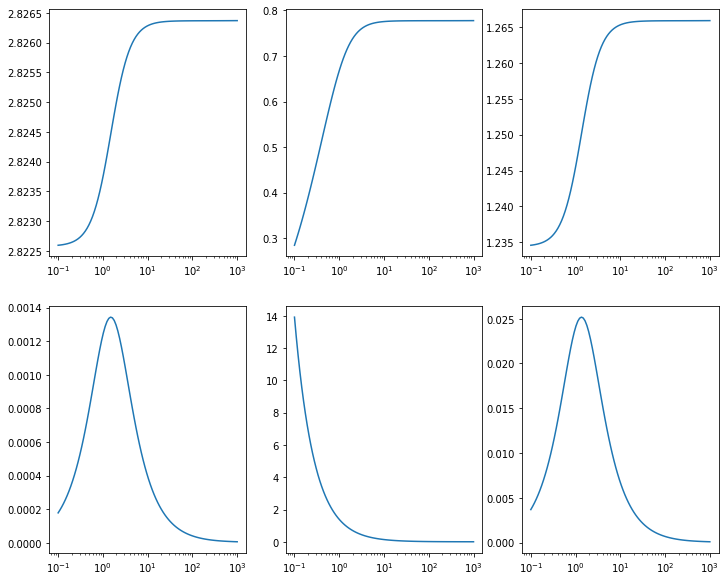

In [132]:
plt.figure(figsize=(12,10))
plt.subplot(231)
plt.semilogx(freq,Vp_fast)
plt.subplot(232)
plt.semilogx(freq,Vp_slow)
plt.subplot(233)
plt.semilogx(freq,Vs)
plt.subplot(234)
plt.semilogx(freq,QP1_inv)
plt.subplot(235)
plt.semilogx(freq,QP2_inv)
plt.subplot(236)
plt.semilogx(freq,Qs_inv)

In [42]:
a=np.array([1,2,3,4,6,7,7,8,10])
idx= a<5
np.sum(idx)

4

In [46]:
a[idx]=3+2j
a


TypeError: can't convert complex to int

5.0